## HW 5.0
What is a data warehouse? What is a Star schema? When is it used?

## HW 5.1
In the database world What is 3NF? Does machine learning use data in 3NF? If so why?   
In what form does ML consume data?  
Why would one use log files that are denormalized?  


## HW 5.2

Using MRJob, implement a hashside join (memory-backed map-side) for left, right and inner joins. 

Run your code on the data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file)). 

In this output please include the webpage URL, webpageID and Visitor ID.:

Justify which table you chose as the Left table in this hashside join.

Please report the number of rows resulting from:

1. Left joining Table Left with Table Right
2. Right joining Table Left with Table Right
3. Inner joining Table Left with Table Right



In [225]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%%writefile MRJoin_5_2.py

from mrjob.job import MRJob, MRStep
import mrjob
import csv
import sys

class MRJoin(MRJob):
    urls = {} # key = pageId, value = url
    keys_emitted = set() # Set of keys of all emitted urls. Used for left join.
    
    def configure_options(self):
        super(MRJoin, self).configure_options()
        self.add_passthrough_option(
            '--joinType', type='str', default="inner")
        
    def load_options(self, args):
        super(MRJoin, self).load_options(args)
        self.joinType = self.options.joinType
        
    def mapper_init(self):
        # Load URL info data file into memory.  
        # Line format: 
        # 1287,/autoroute
        with open("processed_urls.data", "r") as f:
            for fields in csv.reader(f):
                self.urls[fields[0]] = fields[1]

    def mapper(self, line_no, line):
        # Line format: 
        # V,1000,1,C,10001
        fields = csv.reader([line]).next()
        
        key = fields[1]
        url = None
        toEmit = False
        
        if key in self.urls:
            url = self.urls[key]
            
        if self.joinType == "right":
            toEmit = True
        elif self.joinType == "left":
            if url is not None:
                toEmit = True
                self.keys_emitted.add(key) # Remember what we have emitted
        else: # inner join
            if url is not None:
                toEmit = True
        
        if toEmit:
            # Output format
            # pageid, url,V,1,C,10001
            yield key, (url, fields[0], fields[2], fields[3], fields[4])
        
    def mapper_final(self):
        if self.joinType == "left":
            # Emit all the remaining urls
            remaining = set(self.urls.keys()) - self.keys_emitted
            for key in remaining:
                yield key, (self.urls[key], None, None, None, None)
                                
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_init,
                   mapper=self.mapper,
                   mapper_final=self.mapper_final)
            ]
    
if __name__ == '__main__':
    MRJoin.run()


Overwriting MRJoin_5_2.py


In [27]:
from MRJoin_5_2 import MRJoin

for joinType in ["left", "right", "inner"]:
    mr_job = MRJoin(args=['processed_anonymous-msweb.data', 
                        '--file', 'processed_urls.data', # broadcast to every mapper
                        "--strict-protocols",
                        '--joinType', joinType])

    with mr_job.make_runner() as runner: 
        runner.run()

        lines = []
        for line in runner.stream_output():
            lines.append(line)
            
        print "Join type:" + joinType
        print "Number of records:" + str(len(lines))
        print "First 5 lines:"
        for i in range(5):
            print lines[i].strip()
            
        print


Join type:left
Number of records:98663
First 5 lines:
"1000"	["/regwiz", "V", "1", "C", "10001"]
"1001"	["/support", "V", "1", "C", "10001"]
"1002"	["/athome", "V", "1", "C", "10001"]
"1001"	["/support", "V", "1", "C", "10002"]
"1003"	["/kb", "V", "1", "C", "10002"]

Join type:right
Number of records:98654
First 5 lines:
"1000"	["/regwiz", "V", "1", "C", "10001"]
"1001"	["/support", "V", "1", "C", "10001"]
"1002"	["/athome", "V", "1", "C", "10001"]
"1001"	["/support", "V", "1", "C", "10002"]
"1003"	["/kb", "V", "1", "C", "10002"]

Join type:inner
Number of records:98654
First 5 lines:
"1000"	["/regwiz", "V", "1", "C", "10001"]
"1001"	["/support", "V", "1", "C", "10001"]
"1002"	["/athome", "V", "1", "C", "10001"]
"1001"	["/support", "V", "1", "C", "10002"]
"1003"	["/kb", "V", "1", "C", "10002"]



## HW 5.3  EDA of Google n-grams dataset
For the Google n-grams dataset unit test and regression test your code using the 
first 10 lines of the following file:  
``googlebooks-eng-all-5gram-20090715-0-filtered.txt``

Finally show your results on the Google n-grams dataset. 

In particular, this bucket contains (~200) files (10Meg each) in the format:

``	(ngram) \t (count) \t (pages_count) \t (books_count)``

Do some EDA on this dataset using mrjob, e.g., 

- Longest 5-gram (number of characters)
- Top 10 most frequent words (please use the count information), i.e., unigrams
- 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.


In [2]:
%load_ext autoreload
%autoreload 2

### HW5.3a

Find Longest 5-gram (number of characters)


In [58]:
%%writefile MrLongest_5_3a.py

from mrjob.job import MRJob, MRStep
import mrjob
import csv
import sys

# Find Longest 5-gram (number of characters)
class MrLongest(MRJob):
    def mapper(self, line_no, line):
        # Line format: 
        # (ngram) \t (count) \t (pages_count) \t (books_count)
        fields = csv.reader([line], delimiter='\t').next()        
        ngram = fields[0]
        yield len(ngram), ngram

    def reducer_init(self):
        self.emitted = False
        
    def reducer(self, length, values):
        # We only need to emit the first one, which is the longest for this reducer
        if not self.emitted:
            self.emitted = True
            ngrams = [ngram for ngram in values]
            yield length, ngrams
                                
    def steps(self):
        return [
            MRStep(
                mapper=self.mapper,
                reducer_init=self.reducer_init,
                reducer=self.reducer,
                # First key is length; sort it in reverse order
                jobconf={
                    "stream.num.map.output.key.fields":"1",
                    "mapred.output.key.comparator.class":
                        "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapred.text.key.comparator.options":"-k1,1nr"
                          }                
                  )
            ]
    
if __name__ == '__main__':
    MrLongest.run()


Overwriting MrLongest_5_3a.py


#### Unit Tests

In [33]:
# Prepare test file
!head -n 10 googlebooks-eng-all-5gram-20090715-0-filtered.txt > testData.txt

In [83]:
%%writefile unitTest_5_3a.py
import unittest
from MrLongest_5_3a import MrLongest

class UnitTest_5_3(unittest.TestCase):
    
    def __init__(self, *args, **kwargs):
        super(UnitTest_5_3, self).__init__(*args, **kwargs)
        with open('testData.txt', 'r') as f:
            self.first_line = f.readline()
            self.first_ngram = self.first_line.split('\t')[0]
        
    def test_MrLongest_mapper(self):
        j = MrLongest()
        self.assertEqual(j.mapper(None, self.first_line).next(), 
                         (len(self.first_ngram), self.first_ngram))
        
    def test_MrLongest_reducer(self):
        j = MrLongest()
        ngrams = ["0123456789", "A12345678B"]
        length = len(ngrams[0])
        
        j.reducer_init()
        self.assertEqual(j.reducer(length, ngrams).next(), (length, ngrams))

        # We only output the first one.
        with self.assertRaises(StopIteration):
            j.reducer(length, ngrams).next()
        
if __name__ == '__main__':
    unittest.main()

Writing unitTest_5_3a.py


In [84]:
!python unitTest_5_3a.py

..
----------------------------------------------------------------------
Ran 2 tests in 0.004s

OK


#### Full test

In [81]:
%%writefile fullTest_5_3.py
import unittest
from MrLongest_5_3a import MrLongest

class FullTest_5_3a(unittest.TestCase):

    def test_full(self):
        mr_job = MrLongest(
            args=['testData.txt', 
                  # Have to use Hadoop, otherwise custom sort order won't work.
                  '-r', 'hadoop', 
                  '--strict-protocols',
                  # so options from local mrjob.conf don't pollute the test env.
                  '--no-conf', 
                 ])

        results = []
        with mr_job.make_runner() as runner:
            runner.run()
            for line in runner.stream_output():
                # Use the job's specified protocol to read the output
                key, value = mr_job.parse_output_line(line)
                results.append((key, value))

        self.assertEqual(len(results), 1)
        self.assertEqual(results[0], 
                (33, ['A Circumstantial Narrative of the', 'A BILL FOR ESTABLISHING RELIGIOUS']))

if __name__ == '__main__':
    unittest.main()

Overwriting fullTest_5_3.py


In [82]:
!python fullTest_5_3.py

No handlers could be found for logger "mrjob.compat"
.
----------------------------------------------------------------------
Ran 1 test in 37.503s

OK


### Try it on a local hadoop, using just one data file

In [92]:
!python MrLongest_5_3a.py \
googlebooks-eng-all-5gram-20090715-0-filtered.txt \
--jobconf mapred.map.tasks=3 --jobconf mapred.reduce.tasks=1 \
-r hadoop \
--strict-protocols

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrLongest_5_3a.patrickng.20160215.110146.825546
writing wrapper script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrLongest_5_3a.patrickng.20160215.110146.825546/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/patrickng/tmp/mrjob/MrLongest_5_3a.patrickng.20160215.110146.825546/files/
Detected hadoop configuration property names that do not match hadoop version 2.7.1:
The have been translated as follows
 mapred.map.tasks: mapreduce.job.maps
mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.reduce.tasks: mapreduce.job.reduces
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
HADOOP: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
HADOOP: packageJobJar: [/v

### Run it for real on EMR, using all data files

In [94]:
!python MrLongest_5_3a.py \
s3://filtered-5grams/ \
--jobconf mapred.map.tasks=28 --jobconf mapred.reduce.tasks=1 \
-r emr \
--ec2-instance-type m1.xlarge \
--num-ec2-instances 4 \
--emr-tag job=hw5_3a \
--strict-protocols

Got unexpected keyword arguments: ssh_tunnel
no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
using existing scratch bucket mrjob-2c54d3a4b9812930
using s3://mrjob-2c54d3a4b9812930/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrLongest_5_3a.patrickng.20160215.111635.198877
writing master bootstrap script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrLongest_5_3a.patrickng.20160215.111635.198877/b.py
Copying non-input files into s3://mrjob-2c54d3a4b9812930/tmp/MrLongest_5_3a.patrickng.20160215.111635.198877/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API, trying default instance profile: EMR_EC2_DefaultRole
Can't access IAM API, trying default service role: EMR_DefaultRole
Job flow created with ID: j-2X8QEUZQA1863
Setting EMR tags: job=hw5_3a
Created new job flow j-2X8QEUZQA1863
Job launched 32.7s ago, status S

#### Answer
Longest 5-gram:  
Length = 159	

"AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR"  

"ROPLEZIMPREDASTRODONBRASLPKLSON YHROACLMPARCHEYXMMIOUDAVESAURUS PIOFPILOCOWERSURUASOGETSESNEGCP TYRAVOPSIFENGOQUAPIALLOBOSKENUO OWINFUYAIOKENECKSASXHYILPOYNUAT"

### HW5.3b

Top 10 most frequent words (please use the count information), i.e., unigrams


In [278]:
%%writefile MrFrequent_5_3b.py

from mrjob.job import MRJob, MRStep
import mrjob
import csv
import sys

# Top 10 most frequent words (please use the count information), i.e., unigrams
class MrFrequent(MRJob):
    def word_count_mapper(self, line_no, line):
        # Line format: 
        # (ngram) \t (count) \t (pages_count) \t (books_count)
        fields = csv.reader([line], delimiter='\t').next()        
        count = int(fields[1])
        
        for word in fields[0].split():
            yield word.lower(), count

    def sum_word_count_reducer(self, key, counts):
        yield key, sum([count for count in counts])
        
    def top_words_reducer(self, key, counts):
        yield key, counts.next()
                                
    def steps(self):
        return [
            MRStep(
                mapper=self.word_count_mapper,
                combiner=self.sum_word_count_reducer,
                reducer=self.sum_word_count_reducer,
                ),
            MRStep(
                reducer=self.top_words_reducer,
                jobconf={
                    "stream.num.map.output.key.fields":"2",
                    "mapred.output.key.comparator.class":
                        "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapred.text.key.comparator.options":"-k2,2nr",
                    "mapred.reduce.tasks":1
                          }                
                )
            ]
    
if __name__ == '__main__':
    MrFrequent.run()


Overwriting MrFrequent_5_3b.py


In [279]:
%%writefile unitTest_5_3b.py
import unittest
from MrFrequent_5_3b import MrFrequent

class UnitTest_5_3b(unittest.TestCase):
    
    def __init__(self, *args, **kwargs):
        super(UnitTest_5_3b, self).__init__(*args, **kwargs)
        with open('testData.txt', 'r') as f:
            self.first_line = f.readline()
            fields = self.first_line.split('\t')
            self.first_ngram = fields[0].lower()
            self.count = int(fields[1])
            self.first_words = self.first_ngram.split()
        
    def test_MrFrequent_mapper1(self):
        j = MrFrequent()
        self.assertEqual(j.word_count_mapper(None, self.first_line).next(), 
                         (self.first_words[0], self.count))
                
if __name__ == '__main__':
    unittest.main()

Overwriting unitTest_5_3b.py


In [280]:
!python unitTest_5_3b.py

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


#### Try it on local hadoop, using one data file

In [282]:
!python MrFrequent_5_3b.py \
googlebooks-eng-all-5gram-20090715-0-filtered.txt \
-r hadoop \
> topwords-hadoop.txt

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrFrequent_5_3b.patrickng.20160216.094205.039662
writing wrapper script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrFrequent_5_3b.patrickng.20160216.094205.039662/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/patrickng/tmp/mrjob/MrFrequent_5_3b.patrickng.20160216.094205.039662/files/

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

HADOOP: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
HADOOP: packageJobJar: [/var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/hadoop-unjar5860950533453137455/] [] /var/folders/dm/nsw7wjf91

In [283]:
!cat topwords-hadoop.txt | cut -d$'\t' -f 1 | sed 's/"//g' > topwords.txt

### Run it on EMR

In [284]:
!python MrFrequent_5_3b.py \
s3://filtered-5grams/ \
-r emr \
--ec2-instance-type m1.xlarge \
--num-ec2-instances 6 \
--emr-tag job=hw5_3b \
> topwords-emr.txt

Got unexpected keyword arguments: ssh_tunnel
no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
using existing scratch bucket mrjob-2c54d3a4b9812930
using s3://mrjob-2c54d3a4b9812930/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrFrequent_5_3b.patrickng.20160216.094632.911086
writing master bootstrap script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrFrequent_5_3b.patrickng.20160216.094632.911086/b.py

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Copying non-input files into s3://mrjob-2c54d3a4b9812930/tmp/MrFrequent_5_3b.patrickng.20160216.094632.911086/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API, trying defa

#### Answer

Top 10 frequent words:  

In [335]:
!cat topwords-emr.txt | cut -d$'\t' -f 1 | sed 's/"//g' > topwords.txt
!head -10 topwords.txt

the
of
to
in
a
and
that
is
be
as


## HW5.3c

20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 


In [172]:
%%writefile MrDensity_5_3c.py
from __future__ import division
from mrjob.job import MRJob, MRStep
import mrjob
import csv
import sys

# 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing 
# order of relative frequency 
class MrDensity(MRJob):
    emitted = 0
    
    def word_count_mapper(self, line_no, line):
        # Line format: 
        # (ngram) \t (count) \t (pages_count) \t (books_count)
        fields = csv.reader([line], delimiter='\t').next()        
        count = int(fields[1])
        page_count = int(fields[2])
        
        for word in fields[0].split():
            yield word, (count, page_count)

    def get_density_reducer(self, key, values):
        # Sum up the count and the page_count
        (count_total, page_count_total) = reduce(lambda x,y: (x[0]+y[0], x[1]+y[1]), values)
        yield key, count_total/page_count_total # density
        
    def sort_density_reducer(self, key, values):
        yield key, values.next()
                                
    def steps(self):
        return [
            MRStep(
                mapper=self.word_count_mapper,
                reducer=self.get_density_reducer,
                jobconf={
                    "mapred.job.name":"MrDensity-step1",
                    "mapreduce.job.maps":35,
                    "mapreduce.job.reduces":35
                    }
                ),
            
            MRStep(
                reducer=self.sort_density_reducer,
                jobconf={
                    "mapred.job.name":"MrDensity-step2",
                    "stream.num.map.output.key.fields":"2",
                    "mapred.output.key.comparator.class":
                        "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapred.text.key.comparator.options":"-k2,2nr",
                    "mapreduce.job.maps":35,
                    "mapreduce.job.reduces":1
                          }                
                )


            ]
    
if __name__ == '__main__':
    MrDensity.run()


Overwriting MrDensity_5_3c.py


#### Run it on local hadoop using one data file

In [169]:
!python MrDensity_5_3c.py \
googlebooks-eng-all-5gram-20090715-0-filtered.txt \
-r hadoop \
> hw_5_3c.result

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrDensity_5_3c.patrickng.20160215.145730.477553
writing wrapper script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrDensity_5_3c.patrickng.20160215.145730.477553/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/patrickng/tmp/mrjob/MrDensity_5_3c.patrickng.20160215.145730.477553/files/

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Detected hadoop configuration property names that do not match hadoop version 2.7.1:
The have been translated as follows
 mapred.job.name: mapreduce.job.name
HADOOP: Unable to load native-hadoop library for your platform... using builtin-java class

In [170]:
!head -n 20 hw_5_3c.result

"lak"	3.072289156626506
"Honourable"	2.8927536231884057
"Expiration"	2.510204081632653
"operand"	2.353448275862069
"bust"	2.3493975903614457
"houseless"	2.274891774891775
"Gynecological"	2.2481536189069424
"denatured"	2.1864406779661016
"Saving"	2.1129032258064515
"Phe"	2.0408163265306123
"Pathology"	2.021301775147929
"Kiowa"	2.0
"apiece"	1.9607843137254901
"unreachable"	1.9433962264150944
"theres"	1.9230769230769231
"Rumanian"	1.904320987654321
"traitorously"	1.8928571428571428
"pilage"	1.8333333333333333
"Dock"	1.8028169014084507
"aristocrat"	1.7906976744186047


In [171]:
!tail -n 20 hw_5_3c.result

"Absolutist"	1.0
"Ability"	1.0
"Aberdeen"	1.0
"Abdul"	1.0
"Abbotsford"	1.0
"Abbot's"	1.0
"Abbot"	1.0
"Aalborg"	1.0
"AUDACIOUS"	1.0
"zebra"	1.0
"zeolite"	1.0
"zest"	1.0
"AMERICAN"	1.0
"AMERICA"	1.0
"AMAZON"	1.0
"AE"	1.0
"zodiac"	1.0
"nooks"	1.0
"nontrivial"	1.0
"nonsuit"	1.0


#### Run it on EMR

In [173]:
!python MrDensity_5_3c.py \
s3://filtered-5grams/ \
-r emr \
--ec2-instance-type m1.xlarge \
--num-ec2-instances 6 \
--emr-tag job=hw5_3c \
> hw_5_3c-emr.result

Got unexpected keyword arguments: ssh_tunnel
no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
using existing scratch bucket mrjob-2c54d3a4b9812930
using s3://mrjob-2c54d3a4b9812930/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrDensity_5_3c.patrickng.20160215.150403.990340
writing master bootstrap script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrDensity_5_3c.patrickng.20160215.150403.990340/b.py

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Copying non-input files into s3://mrjob-2c54d3a4b9812930/tmp/MrDensity_5_3c.patrickng.20160215.150403.990340/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API, trying default

#### Answers
20 most dense and 20 least dense words

In [174]:
!head -n 20 hw_5_3c-emr.result

"xxxx"	11.557291666666666
"NA"	10.161726044782885
"blah"	8.0741599073001158
"nnn"	7.5333333333333332
"nd"	6.5611436445056839
"ND"	5.4073642846747196
"oooooooooooooooo"	4.921875
"PIC"	4.7272727272727275
"llll"	4.5116279069767442
"LUTHER"	4.3494983277591972
"oooooo"	4.2072378595731514
"NN"	4.0908402725208175
"ooooo"	3.9492846924177396
"OOOOOO"	3.9313725490196076
"IIII"	3.7877030162412995
"lillelu"	3.7624521072796937
"OOOOO"	3.6570701447431206
"Sc"	3.6065624999999999
"Pfeffermann"	3.5769230769230771
"Madarassy"	3.5769230769230771


In [175]:
!tail -n 20 hw_5_3c-emr.result

"AAN"	1.0
"yallowchy"	1.0
"yeelding"	1.0
"yeers"	1.0
"yelloch"	1.0
"yemen"	1.0
"yerne"	1.0
"yestermorn"	1.0
"yleisen"	1.0
"ymounted"	1.0
"yont"	1.0
"youngster's"	1.0
"yproved"	1.0
"zamarra"	1.0
"zein"	1.0
"zeles"	1.0
"zeugmatographic"	1.0
"zoosperms"	1.0
"zuletzt"	1.0
"GOKHALE"	1.0


### HW5.3d

Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

In [218]:
%%writefile MrDistribution_5_3d.py

from mrjob.job import MRJob, MRStep
import mrjob
import csv
import sys

# Distribution of 5-gram sizes (character length). E.g., count (using the count field) 
# up how many times a 5-gram of 50 characters shows up.
class MrDistribution(MRJob):
    def length_count_mapper(self, line_no, line):
        # Line format: 
        # (ngram) \t (count) \t (pages_count) \t (books_count)
        fields = csv.reader([line], delimiter='\t').next()        
        ngram = fields[0]
        yield len(ngram), 1

    def length_sum_reducer(self, length, values):
        yield length, sum([v for v in values])
        
    def length_sort_reducer(self, length, values):
        yield length, values.next()
        
    def steps(self):
        return [
            MRStep(
                mapper=self.length_count_mapper,
                combiner=self.length_sum_reducer,
                reducer=self.length_sum_reducer,
                jobconf={
                    "mapred.job.name":"MrDistribution-step1",
                    "mapreduce.job.maps":21,
                    "mapreduce.job.reduces":21
                    }
                  ),
            MRStep(
                reducer=self.length_sort_reducer,
                jobconf={
                    "mapred.job.name":"MrDistribution-step2",
                    "stream.num.map.output.key.fields":"1",
                    "mapred.output.key.comparator.class":
                        "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapred.text.key.comparator.options":"-k1,1n",
                    "mapreduce.job.maps":21,
                    "mapreduce.job.reduces":1
                          }                
                )
            ]
    
if __name__ == '__main__':
    MrDistribution.run()


Overwriting MrDistribution_5_3d.py


#### Run it using local hadoop on one data file

In [183]:
!python MrDistribution_5_3d.py \
googlebooks-eng-all-5gram-20090715-0-filtered.txt \
-r hadoop

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrDistribution_5_3d.patrickng.20160215.155756.872061
writing wrapper script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrDistribution_5_3d.patrickng.20160215.155756.872061/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/patrickng/tmp/mrjob/MrDistribution_5_3d.patrickng.20160215.155756.872061/files/

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

HADOOP: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
HADOOP: packageJobJar: [/var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/hadoop-unjar4375792671918037377/] [] /var/folders/

#### Run it on EMR

In [220]:
!python MrDistribution_5_3d.py \
s3://filtered-5grams/ \
-r emr \
--ec2-instance-type m1.xlarge \
--num-ec2-instances 4 \
--emr-tag job=hw5_3d \
> hw_5_3d-emr.result

Got unexpected keyword arguments: ssh_tunnel
no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
using existing scratch bucket mrjob-2c54d3a4b9812930
using s3://mrjob-2c54d3a4b9812930/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrDistribution_5_3d.patrickng.20160215.163351.813491
writing master bootstrap script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrDistribution_5_3d.patrickng.20160215.163351.813491/b.py

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Copying non-input files into s3://mrjob-2c54d3a4b9812930/tmp/MrDistribution_5_3d.patrickng.20160215.163351.813491/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API,

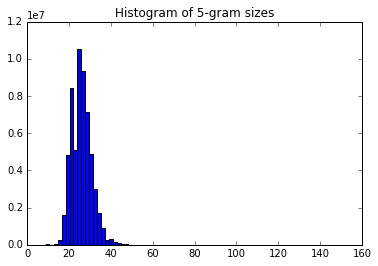

In [463]:
%matplotlib inline
import matplotlib.pyplot as plt

import csv

data = {}
with open("hw_5_3d-emr.result", "r") as f:
    for fields in csv.reader(f, delimiter="\t"):
        data[int(fields[0])] = int(fields[1])
        
plt.hist(data.keys(), weights=data.values(), bins=80)
plt.title("Histogram of 5-gram sizes")
plt.show()

plt.

## HW5.4 (1)

Build stripes for the most frequent 10,000 words using cooccurrence information based on
the words ranked from 1,001-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).

#### Get 9,001th to 10,000th most frequent words as our vocab

In [592]:
#!sed -n 9001,10000p topwords.txt > vocab.txt
!sed -n 1001,10000p topwords.txt > vocab.txt
!wc -l vocab.txt

    9000 vocab.txt


In [570]:
%%writefile MrStripes_5_4_1.py

from mrjob.job import MRJob, MRStep
import mrjob
import csv
import sys
import re
from collections import defaultdict

def mergeStripes(x,y):
    for k,v in y.items():
        x[k] += v            
    return x    

def addToStripes(stripes,key,word,count):
    if key not in stripes:
        stripes[key] = defaultdict(int)
        
    stripes[key][word] += count

# Build cooccurrence stripes
class MrStripes(MRJob):
    vocab = set()

    def mapper_init(self):
        with open("vocab.txt") as f:
            for word in f.readlines():
                self.vocab.add(word.strip().lower())
    
    def mapper(self, line_no, line):
        [ngram,count,pages,books] = re.split("\t",line.strip())
        ngram = ngram.lower() # Should we????
        count = int(count)
        
        # keep only those words found in vocab.txt
        words = filter(lambda w: w in self.vocab, re.split(" ",ngram))  
        
        # Build cooccurrence stripe for each remaining word
        stripes = {} 
        words = sorted(words) # To help avoid pairing up identical items
        for i in range(len(words)-1):
            word1 = words[i]
            for j in range(i+1, len(words)):
                word2 = words[j]
                if word1 == word2:
                    continue
                addToStripes(stripes, word1, word2, count)
                addToStripes(stripes, word2, word1, count)
            
        for key, stripe in stripes.items():
            yield key, stripe   
    
    def reducer(self, key, values):
        # merge the stripes
        merged = defaultdict(int)
        reduce(lambda x,y: mergeStripes(x,y), values, merged)
        yield key, merged
                                
    def steps(self):
        return [
            MRStep(
                mapper_init=self.mapper_init,
                mapper=self.mapper,
                combiner=self.reducer,
                reducer=self.reducer,
                ),
            ]
    
if __name__ == '__main__':
    MrStripes.run()


Overwriting MrStripes_5_4_1.py


#### Unit Test

In [571]:
%%writefile MrStripes_unit_test_5_4_1.py
import unittest
from MrStripes_5_4_1 import MrStripes

class MrStripes_5_4_1(unittest.TestCase):

    def test_full(self):
        mr_job = MrStripes(
            args=['testInput_5_4_1.txt', 
                  '--file', 'vocabTest_5_4_1.txt#vocab.txt', \
                  '-r', 'inline', 
                  '-q',
                  # so options from local mrjob.conf don't pollute the test env.
                  '--no-conf', 
                 ])

        results = []
        with mr_job.make_runner() as runner:
            runner.run()
            for line in runner.stream_output():
                results.append(line)

        with open("testOutput_5_4_1.txt", "r") as f:
            for x,y in zip(results, f.readlines()):
                self.assertEqual(x.strip(),y.strip())

if __name__ == '__main__':
    unittest.main()

Overwriting MrStripes_unit_test_5_4_1.py


In [572]:
!python MrStripes_unit_test_5_4_1.py

No handlers could be found for logger "mrjob.runner"
.
----------------------------------------------------------------------
Ran 1 test in 0.033s

OK


#### Try on local machine using one input file

In [594]:
!python MrStripes_5_4_1.py \
googlebooks-eng-all-5gram-20090715-0-filtered.txt \
--file vocab.txt \
-r local \
-q | sort > result_stripes_5_4_1-local.txt

#### Run it on EMR and save to output to S3

In [595]:
!aws s3 rb --force s3://patng323-w261-hw541
!aws s3 mb s3://patng323-w261-hw541
!aws s3 cp vocab.txt s3://patng323-w261-hw541/input/vocab.txt

delete: s3://patng323-w261-hw541/input/vocab.txt
delete: s3://patng323-w261-hw541/output/part-00003
delete: s3://patng323-w261-hw541/output/part-00005
delete: s3://patng323-w261-hw541/output/part-00006
delete: s3://patng323-w261-hw541/output/part-00000
delete: s3://patng323-w261-hw541/output/part-00001
delete: s3://patng323-w261-hw541/output/_SUCCESS 
delete: s3://patng323-w261-hw541/output/part-00004
delete: s3://patng323-w261-hw541/output/part-00002
remove_bucket: s3://patng323-w261-hw541/
make_bucket: s3://patng323-w261-hw541/
upload: ./vocab.txt to s3://patng323-w261-hw541/input/vocab.txt


In [596]:
!python MrStripes_5_4_1.py \
s3://filtered-5grams/ \
--file 's3://patng323-w261-hw541/input/vocab.txt#vocab.txt' \
-r emr \
--ec2-instance-type m1.large \
--num-ec2-instances 5 \
--aws-region us-east-1 \
--no-output \
--output-dir=s3://patng323-w261-hw541/output

Got unexpected keyword arguments: ssh_tunnel
no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating new scratch bucket mrjob-cf3b90d8845c25a1
using s3://mrjob-cf3b90d8845c25a1/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrStripes_5_4_1.patrickng.20160218.132711.773804
writing master bootstrap script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrStripes_5_4_1.patrickng.20160218.132711.773804/b.py

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

creating S3 bucket 'mrjob-cf3b90d8845c25a1' to use as scratch space
Copying non-input files into s3://mrjob-cf3b90d8845c25a1/tmp/MrStripes_5_4_1.patrickng.20160218.132711.773804/files/
Waiting 5.0s for S3 eventual consistency
Cre

## HW5.4(2)

Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

In [576]:
%%writefile MrComparison_5_4_2.py

from __future__ import division
from mrjob.job import MRJob, MRStep
import mrjob
import sys
import re
import math
from collections import defaultdict

class MrComparison(MRJob):
    # The output from hw5.4.1 is in JSONProtocol
    INPUT_PROTOCOL = mrjob.protocol.JSONProtocol
    
    METHOD_JACCARD = "jaccard"
    METHOD_COSINE_SIM = "cosine_sim"
    COUNT_MARKER = "*"

    totalCounts = {}

    def configure_options(self):
        super(MrComparison, self).configure_options()
        self.add_passthrough_option(
            '--compareMethod', type='str', default=self.METHOD_JACCARD)
        
    def load_options(self, args):
        super(MrComparison, self).load_options(args)
        self.compareMethod = self.options.compareMethod

    def step1MapSingleEmit(self, val):
        if self.compareMethod == self.METHOD_JACCARD:
            return 1
        elif self.compareMethod == self.METHOD_COSINE_SIM:
            return int(val)**2
        else:
            raise Exception("Unknown compare method:", self.compareMethod)
        
    def step1MapPairEmit(self, xVal, yVal):
        if self.compareMethod == self.METHOD_JACCARD:
            return 1
        elif self.compareMethod == self.METHOD_COSINE_SIM:
            return int(xVal) * int(yVal)
        
    def step2Score(self, x, y, val):
        if self.compareMethod == self.METHOD_JACCARD:
            # score = |A^B| / (|A|+|B|-|A^B|)
            # The parameter val is |A^B|
            return val / (self.totalCounts[x] + self.totalCounts[y] - val) 
        elif self.compareMethod == self.METHOD_COSINE_SIM:
            # score = A.B / ||A||.||B||
            return val / (math.sqrt(self.totalCounts[x])*math.sqrt(self.totalCounts[y]))
    
    # For each term in the stripe, emit a value, and also a value for each of its pair.
    # E.g. for Jaccard, if stripe contains (A:2,B:1,C:2), we'll emit
    # *A1, AB1, AC1, *B1, BC1, *C1
    def mapper1(self, term, stripe):
        # Have to sort it so that we won't get (a,b) and (b,a) at the same time
        # otherwise reducer won't work.  They expect both to arrive as (a,b)
        keys = sorted(stripe.keys()) 
        
        for i in range(len(keys)):
            x = keys[i]
            yield self.COUNT_MARKER + x, self.step1MapSingleEmit(stripe[x])
            
            for j in range(i+1, len(keys)):
                y = keys[j]
                yield (x, y), self.step1MapPairEmit(stripe[x], stripe[y])

    def reducer1(self, key, values):
        if key[0] == self.COUNT_MARKER:
            yield key, reduce(lambda x,y: x + y, values) 
        else:
            yield key, reduce(lambda x,y: x + y, values)  
    
    # Generate the score for each pair of "doc"
    def reducer2(self, key, values):
        if key[0] == self.COUNT_MARKER:
            self.totalCounts[key[1:]] = reduce(lambda x,y: x + y, values) 
        else:
            yield key, self.step2Score(key[0], key[1], values.next())
    
    def steps(self):
        return [
            MRStep(
                mapper=self.mapper1,
                combiner=self.reducer1,
                reducer=self.reducer1,
                ),
            MRStep(
                reducer=self.reducer2,
                jobconf={
                    "mapred.reduce.tasks":1 
                    }
                ),
            ]
    
if __name__ == '__main__':
    MrComparison.run()


Overwriting MrComparison_5_4_2.py


#### Try Stripe of stripe

In [680]:
%%writefile MrComparison_5_4_2.py

from __future__ import division
from mrjob.job import MRJob, MRStep
import mrjob
import sys
import re
import math
from collections import defaultdict

def mergeStripes(x,y):
    for k,v in y.items():
        if k in x:
            x[k] += v
        else:
            x[k] = v
    return x    

class MrComparison(MRJob):
    # The output from hw5.4.1 is in JSONProtocol
    INPUT_PROTOCOL = mrjob.protocol.JSONProtocol
    
    METHOD_JACCARD = "jaccard"
    METHOD_COSINE_SIM = "cosine_sim"
    COUNT_MARKER = "*"

    totalCounts = {}
    
    def configure_options(self):
        super(MrComparison, self).configure_options()
        self.add_passthrough_option(
            '--compareMethod', type='str', default=self.METHOD_JACCARD)
        
    def load_options(self, args):
        super(MrComparison, self).load_options(args)
        self.compareMethod = self.options.compareMethod

    def step1MapSingleEmit(self, val):
        if self.compareMethod == self.METHOD_JACCARD:
            return 1
        elif self.compareMethod == self.METHOD_COSINE_SIM:
            return int(val)**2
        else:
            raise Exception("Unknown compare method:", self.compareMethod)
        
    def step1MapPairUpdateStripe(self, stripe, x, y, xVal, yVal):
        if self.compareMethod == self.METHOD_JACCARD:
            val = 1
        elif self.compareMethod == self.METHOD_COSINE_SIM:
            val = int(xVal) * int(yVal)
        
        assert y not in stripe[x], "Don't expect y to appear twice under x"
        stripe[x][y] = val
        
    def step2Score(self, x, y, val):
        if self.compareMethod == self.METHOD_JACCARD:
            # score = |A^B| / (|A|+|B|-|A^B|)
            # The parameter val is |A^B|
            return val / (self.totalCounts[x] + self.totalCounts[y] - val) 
        elif self.compareMethod == self.METHOD_COSINE_SIM:
            # score = A.B / ||A||.||B||
            return val / (math.sqrt(self.totalCounts[x])*math.sqrt(self.totalCounts[y]))
        
    # For each term in the stripe, emit a value, and also a value for each of its pair.
    # E.g. for Jaccard, if stripe contains (A:2,B:1,C:2), we'll emit
    # *A1, AB1, AC1, *B1, BC1, *C1
    def mapper1(self, term, postings):
        # Have to sort it so that we won't get (a,b) and (b,a) at the same time
        # otherwise reducer won't work.  They expect both to arrive as (a,b)
        keys = sorted(postings.keys()) 
        stripe = defaultdict(dict)
        
        for i in range(len(keys)):
            x = keys[i]
            yield self.COUNT_MARKER + x, self.step1MapSingleEmit(postings[x])
            
            for j in range(i+1, len(keys)):
                y = keys[j]
                self.step1MapPairUpdateStripe(stripe, x, y, postings[x], postings[y])
                
        # Emit all the stripes
        for k, v in stripe.items():
            yield k, v

    def reducer1(self, key, values):
        if key[0] == self.COUNT_MARKER:
            yield key, reduce(lambda x,y: x + y, values) 
        else:
            yield key, reduce(lambda x,y: mergeStripes(x,y), values)  
    
    # Generate the score for each pair of "doc"
    def reducer2(self, key, values):
        if key[0] == self.COUNT_MARKER:
            self.totalCounts[key[1:]] = reduce(lambda x,y: x + y, values) 
        else:
            stripe = values.next()
            for word, val in stripe.items():
                yield (key, word), self.step2Score(key, word, val)
                
    def reducer3(self, key, values):
        for v in values:
            yield v, key
    
    def steps(self):
        return [
            MRStep(
                mapper=self.mapper1,
                combiner=self.reducer1,
                reducer=self.reducer1,
                ),
            MRStep(
                reducer=self.reducer2,
                jobconf={
                    "mapred.reduce.tasks":1 
                    }
                ),
            ]
    
if __name__ == '__main__':
    MrComparison.run()


Overwriting MrComparison_5_4_2.py


In [681]:
!python MrComparison_5_4_2.py \
-r inline \
test_5_4_2.inverted.index \
--compareMethod 'jaccard' \
-q

["A", "C"]	0.4
["A", "B"]	0.6666666666666666
["B", "C"]	0.2


In [682]:
!python MrComparison_5_4_2.py \
-r inline \
test_5_4_2.inverted.index \
--compareMethod 'cosine_sim' \
-q

["A", "C"]	0.5184476595525866
["A", "B"]	0.7004041959724749
["B", "C"]	0.9026976808426486


In [639]:
%%writefile MrComparison_unit_test_5_4_2.py
import unittest
from MrComparison_5_4_2 import MrComparison

class MrComparison_5_4_2(unittest.TestCase):

    def test_full(self):
        methods = ['jaccard', "cosine-sim"]
        for method in methods:
            print "Testing method:", method
            results = []
            
            mr_job = MrComparison(
                args=['test_5_4_2.inverted.index', 
                      '-r', 'inline', 
                      '--compareMethod', method,
                      '-q',
                      # so options from local mrjob.conf don't pollute the test env.
                      '--no-conf', 
                     ])

            with mr_job.make_runner() as runner:
                runner.run()
                for line in runner.stream_output():
                    results.append(line)

            with open("testOutput_5_4_2." + method + ".txt", "r") as f:
                for x,y in zip(results, f.readlines()):
                    self.assertEqual(x.strip(),y.strip())

if __name__ == '__main__':
    unittest.main()

Overwriting MrComparison_unit_test_5_4_2.py


In [640]:
!python MrComparison_unit_test_5_4_2.py

Testing method: jaccard
No handlers could be found for logger "mrjob.runner"
.
----------------------------------------------------------------------
Ran 1 test in 0.049s

OK


#### Test comparisons with a small index on local machine

In [683]:
!python MrComparison_5_4_2.py \
test_5_4_2-small.inverted.index \
--compareMethod 'jaccard' \
-r local \
-q \
> output_5_4_2-jaccard.txt

!echo "Head:"
!head output_5_4_2-jaccard.txt

!echo
!echo "Tail:"
!tail output_5_4_2-jaccard.txt


Head:
["alternate", "telescope"]	1.0
["amidst", "herds"]	0.3333333333333333
["ammonium", "soda"]	1.0
["articular", "localized"]	0.5
["careless", "impatience"]	1.0
["cartilage", "discomfort"]	0.5
["ce", "est"]	1.0
["ce", "commence"]	0.5
["commence", "est"]	0.5
["establishments", "inspector"]	1.0

Tail:
["establishments", "inspector"]	1.0
["flocks", "restless"]	0.5
["fossil", "resembling"]	1.0
["fossil", "polished"]	1.0
["intolerable", "rejoiced"]	1.0
["palestinian", "qui"]	0.3333333333333333
["peritoneal", "uterine"]	1.0
["polished", "resembling"]	1.0
["replacing", "wax"]	1.0
["restless", "tumult"]	0.5


In [675]:
!python MrComparison_5_4_2.py \
test_5_4_2-small.inverted.index \
--compareMethod 'cosine_sim' \
-r local \
-q \
> output_5_4_2-cosine_sim.txt

!echo "Head:"
!head output_5_4_2-cosine_sim.txt

!echo
!echo "Tail:"
!tail output_5_4_2-cosine_sim.txt


Head:
["amidst", "herds"]	0.020988688248806096
["palestinian", "qui"]	0.5491356084120524
["restless", "tumult"]	0.7071067811865475
["cartilage", "discomfort"]	0.7071067811865476
["flocks", "restless"]	0.7071067811865476
["ce", "commence"]	0.7127408280944525
["commence", "est"]	0.7127408280944525
["articular", "localized"]	0.7645223227757786
["alternate", "telescope"]	1.0
["ammonium", "soda"]	1.0

Tail:
["ammonium", "soda"]	1.0
["careless", "impatience"]	1.0
["ce", "est"]	1.0
["establishments", "inspector"]	1.0
["fossil", "polished"]	1.0
["fossil", "resembling"]	1.0
["intolerable", "rejoiced"]	1.0
["peritoneal", "uterine"]	1.0
["polished", "resembling"]	1.0
["replacing", "wax"]	1.0


#### Run it in EMR and output the result to s3

In [678]:
!aws s3 rb --force s3://patng323-w261-hw542-jaccard
!aws s3 mb s3://patng323-w261-hw542-jaccard

remove_bucket: s3://patng323-w261-hw542-jaccard/
make_bucket: s3://patng323-w261-hw542-jaccard/


In [684]:
!python MrComparison_5_4_2.py \
s3://patng323-w261-hw541/output/ \
-r emr \
--compareMethod 'jaccard' \
--ec2-instance-type m1.large \
--num-ec2-instances 5 \
--aws-region us-east-1 \
--ec2-key-pair w261 \
--ec2-key-pair-file /Users/patrickng/.ssh/w261.pem \
--output-dir=s3://patng323-w261-hw542-jaccard/output/ \
--emr-tag job='HW542_Jaccard' \
--no-output \

Got unexpected keyword arguments: ssh_tunnel
no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating new scratch bucket mrjob-47453eb3eb0cb961
using s3://mrjob-47453eb3eb0cb961/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrComparison_5_4_2.patrickng.20160219.180217.803509
writing master bootstrap script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrComparison_5_4_2.patrickng.20160219.180217.803509/b.py

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

creating S3 bucket 'mrjob-47453eb3eb0cb961' to use as scratch space
Copying non-input files into s3://mrjob-47453eb3eb0cb961/tmp/MrComparison_5_4_2.patrickng.20160219.180217.803509/files/
Waiting 5.0s for S3 eventual consis

In [685]:
!aws s3 rb --force s3://patng323-w261-hw542-cosine
!aws s3 mb s3://patng323-w261-hw542-cosine

remove_bucket: s3://patng323-w261-hw542-cosine/
make_bucket: s3://patng323-w261-hw542-cosine/


In [686]:
!python MrComparison_5_4_2.py \
s3://patng323-w261-hw541/output/ \
-r emr \
--compareMethod 'cosine_sim' \
--ec2-instance-type m1.large \
--num-ec2-instances 9 \
--aws-region us-east-1 \
--output-dir=s3://patng323-w261-hw542-cosine/output/ \
--ec2-key-pair w261 \
--ec2-key-pair-file /Users/patrickng/.ssh/w261.pem \
--no-output \
--emr-tag job='HW542_Cosine' \
    
#!aws s3 cp s3://patng323-w261-hw542-test/output/part-00000 output_5_4_2-jaccard-emr.txt

Got unexpected keyword arguments: ssh_tunnel
no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating new scratch bucket mrjob-33908752ab4786c3
using s3://mrjob-33908752ab4786c3/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrComparison_5_4_2.patrickng.20160220.005132.391897
writing master bootstrap script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrComparison_5_4_2.patrickng.20160220.005132.391897/b.py

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

creating S3 bucket 'mrjob-33908752ab4786c3' to use as scratch space
Copying non-input files into s3://mrjob-33908752ab4786c3/tmp/MrComparison_5_4_2.patrickng.20160220.005132.391897/files/
Waiting 5.0s for S3 eventual consis

In [ ]:
# Download results from both runs
!aws s3 cp s3://patng323-w261-hw542-jaccard/output/part-00000 result-5_4_2-jaccard.txt
!aws s3 cp s3://patng323-w261-hw542-cosine/output/part-00000 result-5_4_2-cosine.txt

## HW 5.5 Evaluation of synonyms that your discovered
```
In this part of the assignment you will evaluate the success of you synonym detector.
Take the top 1,000 closest/most similar/correlative pairs of words as determined
by your measure in (2), and use the synonyms function in the accompanying
python code:

nltk_synonyms.py

Note: This will require installing the python nltk package:

http://www.nltk.org/install.html

and downloading its data with nltk.download().

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.
```


In [608]:
%%writefile hw_5_5.py
#!/usr/bin/python2.7
from __future__ import division
import nltk
from nltk.corpus import wordnet as wn
import sys
import re
from collections import defaultdict

''' pass a string to this funciton ( eg 'car') and it will give you a list of
words which is related to cat, called lemma of CAT. '''
#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()

# In the top 1000 records, for each word, build up its own synonym list by
# including all the words which appear as similar.
m = re.compile(r"\[\"(\S+)\"\,\s*\"(\S+)\"\].+")
n = 1000
simResults = defaultdict(list)
vocab = set()

simResultFile = sys.argv[1]
vocabFile = sys.argv[2]

with open(simResultFile, "r") as f:
    for i in range(n):
        line = f.readline()
        matched = m.match(line)
        word1 = matched.group(1)
        word2 = matched.group(2)

        # Store the synonyms of word1, and vice-versa for word2
        simResults[word1].append(word2)
        simResults[word2].append(word1)

with open(vocabFile, "r") as f:
    for word in f.readlines():
        vocab.add(word.strip())
    
# Now we have the list of top words and the synonyms of each word.

# Calculate the precision, recall and f1 of each word
def calStats(word, similarWords):
    # We will use only those synonyms listed in our vocab.
    syns = set(synonyms(word)) & vocab
    
    correct = 0
    for word in similarWords:
        if word in syns:
            correct += 1

    precision = correct / len(similarWords)
    recall = 0 if len(syns) == 0 else correct / len(syns)
    if (precision + recall) == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

precisionTotal = 0
recallTotal = 0
f1Total = 0

print "From:", simResultFile
print "-----------------------------"
print "Word, precision, recall, F1"
for word, similarWords in simResults.items():
    precision, recall, f1 = calStats(word, similarWords)
    precisionTotal += precision
    recallTotal += recall
    f1Total += f1
    print "Word:", word, "\t\tStats:", (precision, recall, f1)

print
print "Summary:"
print "-----------------------------"
print "Precision average:", precisionTotal / len(simResults)
print "Recall average:", recallTotal / len(simResults)
print "F1 average:", f1Total / len(simResults)

print 


Overwriting hw_5_5.py


#### Run it for the Jaccard result

In [ ]:
# Sort the result from HW5.4(2)
!sort -t$'\t' -k2,2gr result-5_4_2-jaccard.txt > result-5_4_2-jaccard-sorted.txt

In [609]:
!python hw_5_5.py result-5_4_2-jaccard-sorted.txt vocab.txt > result-hw_5_5-jaccard.txt

#### Run it for the Cosine result

In [ ]:
# Sort the result from HW5.4(2)
!sort -t$'\t' -k2,2gr result-5_4_2-cosine.txt > result-5_4_2-jaccard-cosine.txt

In [610]:
!python hw_5_5.py result-5_4_2-cosine-sorted.txt vocab.txt > result-hw_5_5-cosine.txt